In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import all the necessary bits and bobs

import h5py, sys, os
import numpy as np
import pandas
# import scipy
# import multiprocessing
from pathlib import Path

# load required modules
homedir = os.path.expanduser("~")
# disable OpenCL for multiprocessing on CPU
os.environ["SAS_OPENCL"] = "none"

# CHANGE to location where the SasView/sasmodels are installed
sasviewPath = os.path.join(homedir, "Code", "sasmodels")  # <-- change! 
if sasviewPath not in sys.path:
    sys.path.append(sasviewPath)
# import from this path
import sasmodels
import sasmodels.core
import sasmodels.direct_model

# CHANGE this one to whereever you have mcsas3 installed:
mcsasPath = os.path.join(homedir, "Code", "mcsas3")  # <-- change!
if mcsasPath not in sys.path:
    sys.path.append(mcsasPath)

# import from this path:
from mcsas3 import McHat
from mcsas3 import McData1D, McData2D
from mcsas3.mcmodelhistogrammer import McModelHistogrammer
from mcsas3.mcanalysis import McAnalysis
# optimizeScalingAndBackground: takes care of the calculation of the reduced chi-squared value, after a least-squares optimization for the scaling and background factors.
# McModel: extends the SasModel with information on the parameter set and methods for calculating a total scattering intensity from multiple contributions. It also tracks parameter bounds, random generators and picks.
# McOpt: contains mostly settings related to the optimization process. Also keeps track of the contribution to optimize.
# McCore: Contains the methods required to do the optimization. 

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

## Results dump file

In [3]:
test_file = '/home/bgpelkie/Code/saxs_data_processing/brenden_prototype/test_1d/01cddefc-e6a6-41aa-9052-06286b12b8fe.dat'

In [4]:
# set a filename for documenting the fit:
resPath = Path("mcsas_test", "01cddefc-e6a6-41aa-9052-06286b12b8fe_fitResult.h5")
# delete if it exists:
if resPath.is_file(): resPath.unlink()

In [5]:
os.get_cwd()

AttributeError: module 'os' has no attribute 'get_cwd'

## Data loading:

In [16]:
# measurement data:
mds = McData1D.McData1D(
    filename=Path("test_1d", "01cddefc-e6a6-41aa-9052-06286b12b8fe.dat"),
    nbins=100, # no rebinning in this example
    #dataRange = [0.01, 1], # this clips the data to the specified range

    # arguments for pandas.read_csv:
    csvargs = {"sep" : "\s+|\t+|\s+\t+|\t+\s+", # field delimiter, for flexible whitespace, use: "\s+|\t+|\s+\t+|\t+\s+" (https://stackoverflow.com/questions/15026698/how-to-make-separator-in-pandas-read-csv-more-flexible-wrt-whitespace-for-irreg#15026839)
               "skipinitialspace" : True, # ignore initial blank spaces
               "skip_blank_lines" : True, # ignore lines with nothing in them
               "skiprows" : 149, # skip this many rows before reading data (useful for PDH, which I think has five (?) header rows?)
               "engine": "python", # most flexible
               "header" : None, # let's not read any column names since they're unlikely to match with our expected column names:
               "names": ["Q", "I", "ISigma"], # our expected column names
               "index_col" : False}, # no index column before every row (who does this anyway?)
)

# store the data and all derivatives in the output file:
mds.store(resPath)

# plot the loaded data
fhs, ahs = plt.subplots(nrows = 1, ncols = 1, figsize = [6, 4])
mds.rawData.plot('Q', 'I', yerr= 'ISigma', ax = ahs, label = 'As provided data')
mds.clippedData.plot('Q', 'I', yerr= 'ISigma', ax = ahs, label = 'clipped data')
mds.binnedData.plot('Q', 'I', yerr= 'ISigma', ax = ahs, label = 'binned data')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q (1/nm)')
plt.ylabel('I (1/(m sr))')
# plt.xlim([0.1, 3])
print(f'data fed to McSAS3 is {mds.measDataLink}')
md = mds.measData.copy() # here we copy the data we want for fitting.

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_78074/1537497607.py:8: SyntaxWarning: invalid escape sequence '\s'
  csvargs = {"sep" : "\s+|\t+|\s+\t+|\t+\s+", # field delimiter, for flexible whitespace, use: "\s+|\t+|\s+\t+|\t+\s+" (https://stackoverflow.com/questions/15026698/how-to-make-separator-in-pandas-read-csv-more-flexible-wrt-whitespace-for-irreg#15026839)
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/mcsas3/McData1D.py:167: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  binDat.I.loc[binN] = float(dfRange.I)
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/mcsas3/McData1D.py:167: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which wi

data fed to McSAS3 is binnedData


In [17]:
mds.dataRange = [md['Q'][0].min(), md['Q'][0].max()]

In [18]:
mds.dataRange

[0.0221577545024433, 0.37668182654153715]

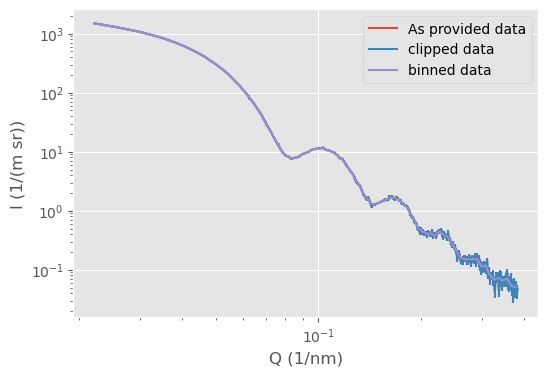

In [19]:
plt.show()

## Set up model

In [20]:
model = sasmodels.core.load_model_info('sphere')

In [21]:
# configures the model the Monte Carlo optimizer:

mh = McHat.McHat(
            modelName="sphere", # the model name chosen from the list above
            nContrib=300, # number of contributions, 300 normally suffice
            modelDType="default", # choose "fast" for single-precision calculations at your own risk
            fitParameterLimits={"radius": (20, 250)}, # this is the parameter we want to MC optimize within these bounds
            staticParameters={ # these are the parameters we don't want to change:
                "background": 0, # is optimized separately, always set to zero
                "scale": 1, # ibid.
                "sld": 8.575, # SLD of silver 
                "sld_solvent": 9.611,# SLD of water
                },
            maxIter=50000, # don't try more than this many iterations
            convCrit=1, # convergence criterion, should be 1 if reasonable uncertainty estimates are provided, to prevent over- or under-fitting
            nRep=10, # number of independent repetitions of the optimization procedure. 10 for fast, 50-100 for publications
            nCores = 6, # number of threads to spread this over. Set to 0 for automatic detection of maximum number of threads
            seed=None, # random number generator seed. Set to a specific value for reproducible random numbers
        )
mh.store(resPath)

## Fit Model

In [22]:
mh.run(md, resPath)

McSAS analysis with 10 repetitions took 30.7s with 6 threads.
Optimization of repetition 0 started:
chiSqr: 953.3411577293081, N accepted: 0 / 0
chiSqr: 953.3411577293081, N accepted: 0 / 1
chiSqr: 127.5158792005874, N accepted: 359 / 1001
chiSqr: 33.75762804474545, N accepted: 523 / 2001
chiSqr: 10.032895467160294, N accepted: 632 / 3001
chiSqr: 4.311540290351297, N accepted: 728 / 4001
chiSqr: 2.059515894046794, N accepted: 809 / 5001
chiSqr: 1.3794257733796615, N accepted: 879 / 6001
Final chiSqr: 0.982235986260217, N accepted: 929

Optimization of repetition 1 started:
chiSqr: 858.1858970792481, N accepted: 0 / 0
chiSqr: 858.1819046626043, N accepted: 1 / 1
chiSqr: 58.29720324564531, N accepted: 351 / 1001
chiSqr: 14.994215391709998, N accepted: 503 / 2001
chiSqr: 7.042637844429963, N accepted: 607 / 3001
chiSqr: 3.556524284635878, N accepted: 677 / 4001
chiSqr: 1.918059987019473, N accepted: 749 / 5001
chiSqr: 1.208160555645036, N accepted: 805 / 6001
Final chiSqr: 0.9999913573851

## # histogram the result, This doesn't take so long and can be repeated as required.


In [23]:
# histogram the result, This doesn't take so long and can be repeated as required.
histRanges = pandas.DataFrame(
    [
        dict(
            parameter="radius",  # we only varied one parameter, so not much choice here
            nBin=50,             # number of bins
            binScale="log",      # logarithmically spaced along x
            binWeighting="vol",  # volume weighting (only option as of yet)
            autoRange=True,      # automatically sets min/max to histogram all
        ),
        dict(
            parameter="radius",  # same
            nBin=20,             # but only 20 bins
            binScale="linear",   # linear x-axis spacing
            presetRangeMin=3.14, # minimum
            presetRangeMax=25,   # maximum (only first mode)
            binWeighting="vol",  # volume-weighted
            autoRange=False,     # no auto-ranging (only a subset within the specified parameter range)
        ),
        dict(
            parameter="radius",
            nBin=20,
            binScale="linear",
            presetRangeMin=25,
            presetRangeMax=75,
            binWeighting="vol",
            autoRange=False,
        ),

        dict(
            parameter="radius",
            nBin=20,
            binScale="linear",
            presetRangeMin=75,
            presetRangeMax=150,
            binWeighting="vol",
            autoRange=False,
        ),
    ]
)

mcres = McAnalysis(resPath, md, histRanges, store=True)


Getting List of repetitions...
10 repetitions found in McSAS file mcsas_test/01cddefc-e6a6-41aa-9052-06286b12b8fe_fitResult.h5
Histogramming every repetition and extracting elements to average...


/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/mcsas3/mcmodelhistogrammer.py:168: RuntimeWarning: invalid value encountered in scalar divide
  skw = sum((rset - mu) ** 3 * frac) / (sum(frac) * sigma**3)
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/mcsas3/mcmodelhistogrammer.py:169: RuntimeWarning: invalid value encountered in scalar divide
  krt = sum((rset - mu) ** 4 * frac) / (sum(frac) * sigma**4)
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/mcsas3/mcmodelhistogrammer.py:168: RuntimeWarning: invalid value encountered in scalar divide
  skw = sum((rset - mu) ** 3 * frac) / (sum(frac) * sigma**3)
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/mcsas3/mcmodelhistogrammer.py:169: RuntimeWarning: invalid value encountered in scalar divide
  krt = sum((rset - mu) ** 4 * frac) / (sum(frac) * sigma**4)
/home/bgpelkie/miniconda3/envs/sas/lib/python3.12/site-packages/mcsas3/mcmodelhistogrammer.py:168: RuntimeWarning: inval

Averaging population modes...
Averaging histograms...
Averaging optimization parameters...
Averaging model intensity...
Storing averages...


## plot

In [24]:
## plot the histogram result in a report similar to the original McSAS
# Set up the plotting frame
fhs, ahs = plt.subplots(
    nrows = 2, 
    ncols = 1+len(histRanges), 
    figsize = [6 * (1+len(histRanges)), 5], 
    gridspec_kw={
        'width_ratios':list(np.ones(len(histRanges) + 1)), 
        'height_ratios':[1,2]
        }
    )
csfont = {'fontname':'Courier New'}


# plot a histogram for every histRange:
for histNum, histRange in histRanges.iterrows():
    histDataFrame = mcres._averagedHistograms[histNum]
    plt.sca(ahs[1, 1 + histNum])
    plt.bar(
        histDataFrame['xMean'], 
        histDataFrame['yMean'], 
        align = 'center', 
        width = histDataFrame['xWidth'],
        yerr = histDataFrame['yStd'],
        facecolor = 'orange',
        edgecolor = 'black',
        ecolor = 'red',
        )
    plt.xscale(histRange.binScale)
    plt.xlabel('Size (nm)')
    plt.ylabel('Volume fraction (arb. units)')

    # get report, some string replacements to prevent errors of "missing Glyph (9), which is the tab"
    histReport = mcres.debugReport(histNum)#.split('\n', 1)[1]
    plt.sca(ahs[0, 1 + histNum]) # top right
    ahs[0,1 + histNum].set_aspect(1)
    ahs[0,1 + histNum].axis('off')
    ahs[0,1 + histNum].text(.2, 0, histReport, **csfont, 
        rotation=0,
        horizontalalignment='center',
        verticalalignment='bottom',
        multialignment='left',
        transform=ahs[0,1 + histNum].transAxes,
        bbox=dict(facecolor='white', alpha=0)
    )


# plot data and fit:
plt.sca(ahs[1, 0])
mds.binnedData.plot('Q', 'I', yerr= 'ISigma', ax = ahs[1,0], label = 'Measured data', zorder = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Q (1/nm)')
plt.ylabel('I (1/cm)')
# plt.xlim(1e-1, 2)
plt.plot(mcres._measData['Q'][0], mcres.modelIAvg.modelIMean.values, zorder = 2, label = 'McSAS3 result')
plt.legend()

# plot fitting statistics:
runReport = mcres.debugRunReport().split('\n', 1)[1]
plt.sca(ahs[0, 0])
ahs[0,0].set_aspect(1)
ahs[0,0].axis('off')
ahs[0,0].text(.2, 0, runReport, **csfont, 
    rotation=0,
    horizontalalignment='center',
    verticalalignment='bottom',
    multialignment='left',
    transform=ahs[0,0].transAxes,
    bbox=dict(facecolor='white', alpha=0)
)
plt.tight_layout()


# save into PDF:
#plt.savefig(Path(resPath.parent, resPath.stem+'.pdf'))

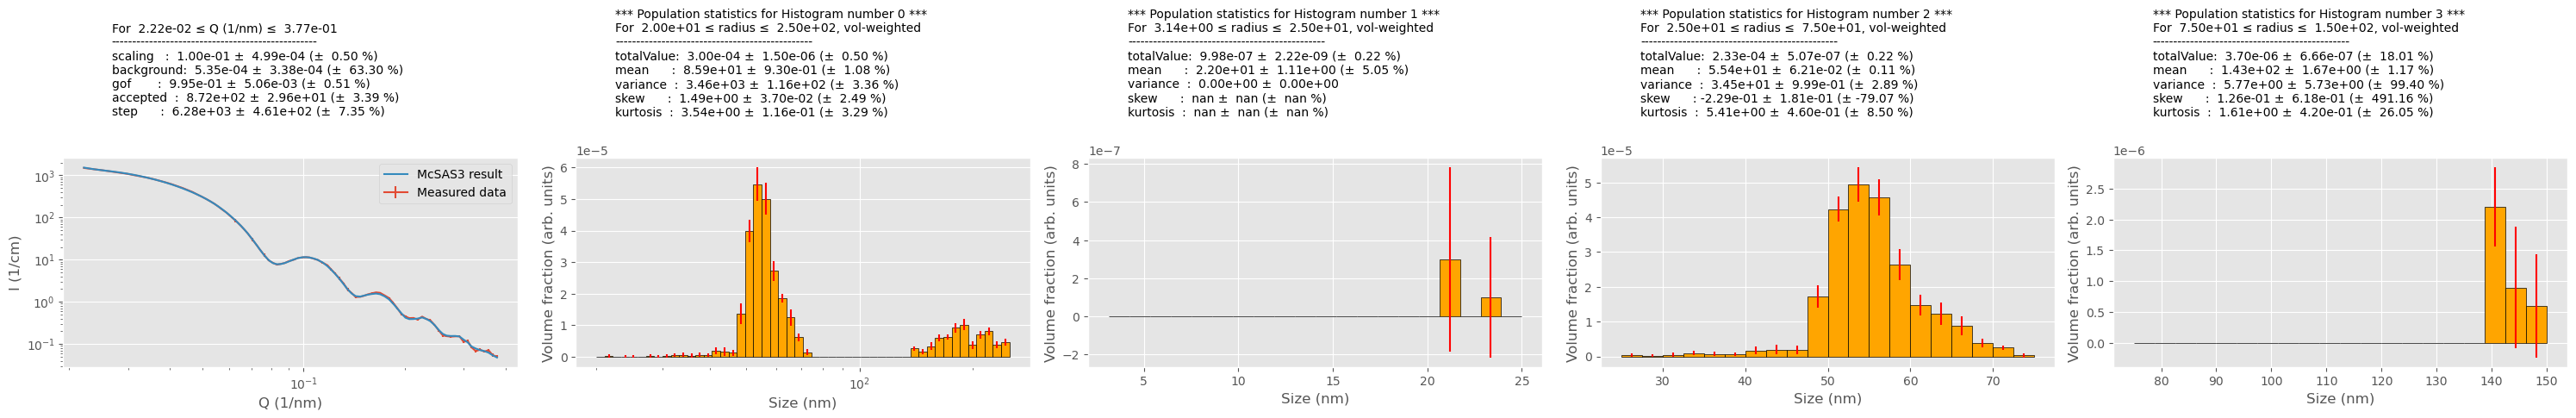

In [25]:
plt.show()

In [28]:
mcres.

,xMean,xWidth,yMean,yStd,Obs,cdfMean,cdfStd
0,3.6865,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
1,4.7795,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
2,5.8725,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
3,6.9655,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
4,8.0585,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
5,9.1515,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
6,10.2445,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
7,11.3375,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
8,12.4305,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
9,13.5235,1.093,0.000000e+00,0.000000e+00,NaN,NaN,NaN
